<a href="https://colab.research.google.com/github/jfdoppler/DNL-1c2020/blob/master/DNL_1C2020_integracion_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Integración III 
Colabs gentileza de Juan Doppler.
# Algunos extras útiles

### Extra 1: Cómo pasarle al odeint un argumento que varía en el tiempo
A veces las ecuaciones diferenciales tienen parámetros que varían en el tiempo. Por ejemplo, en el ejercicio del switch vimos qué pasaba cuando aumentabamos el s y luego lo disminuiamos para distintos valores de r.

Una forma de hacer esto con el odeint es la siguiente:

In [0]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy import signal


Como siempre, definimos el campo vector. La particularidad del caso es que dentro del campo vector vamos a tener una función (que vamos a tener que definir más adelante) que va depender del tiempo. Esta función la va a ir llamando el odeint cuando la necesite.

En el ejemplo que sigue es la que llamamos sfunc

In [0]:
def f(x, t, r):
    dxdt = sfunc(t) - r*x + x**2/(1+x**2)
    return dxdt

Una forma de definir una función es haciendo una interpolación de puntos, usando la función interp1d de scipy.interpolate.

Para usar este método, tenemos que dar una serie de puntos (eje temporal) y los valores de la función en esos puntos. Arranquemos definiendo el vector de tiempos:

In [0]:
tmax = 1000.
dt = 1./100
t = np.arange(0, tmax, dt)


Ahora tenemos que darle valores a la función en esos puntos. Hagamos como ejemplo que la función es medio período de una senoidal (sube y baja) y después se queda en cero. Para simplificar, arranquemos con una oscilación completa, es decir que un período sea exactamente tmax

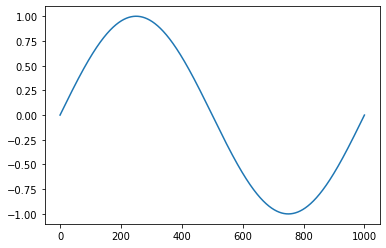

In [7]:
periodo = tmax
st = np.sin(2*np.pi*t/periodo)
plt.plot(t, st)

Y ahora reemplacemos los valores negativos con ceros

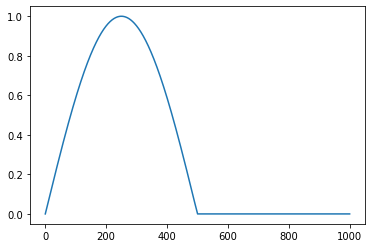

In [8]:
st[st < 0] = 0
plt.plot(t, st)

Para hacer la interpolación hacemos:

`funcion_interp = interp1d(xvalues, yvalues, fill_value='extrapolate')`


El primer argumento son los valores de x (para nosotros los tiempos) donde tenemos los valores de la función, y el segundo cuanto vale la función en esos puntos.

El último argumento le dice que si le preguntamos el valor de la función en algún lugar **por fuera** del rango donde le dimos datos, lo que va a hacer es extrapolar.

Lo que nos devuelve esto es una **función**, que podemos evaluar en valores de x.

In [9]:
# Definimos una función que interpola linealmente a s
sfunc = interp1d(t, st, fill_value='extrapolate')
print(sfunc(1))
print(sfunc(-500))

0.006283143965558951
-3.1415926515227084


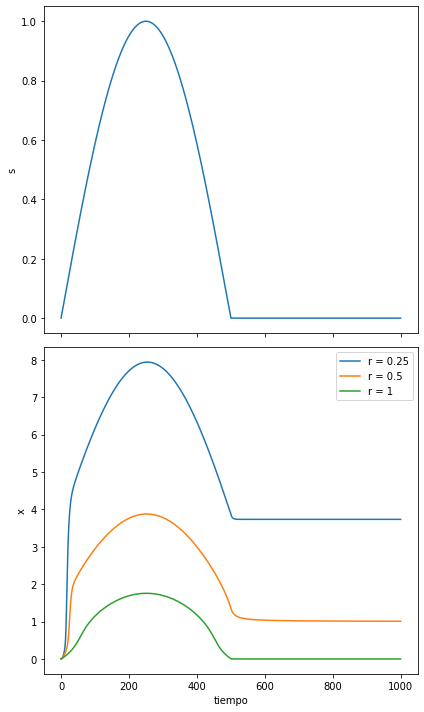

In [10]:
# Para distintos valores de r posibles, vamos a hacer una integración con esta
# función para s
rs = [0.25, .5, 1]

fig, ax = plt.subplots(2, sharex=True, figsize=(6, 10))
ax[0].plot(t, sfunc(t))
ax[0].set_ylabel('s')

for r in rs:
    # Para cada valor de r damos condición inicial en 0 e integramos
    xi = 0
    x = odeint(f, xi, t, args=(r, ))
    ax[1].plot(t, x, label='r = {}'.format(r))
ax[1].legend(loc='upper right')
ax[1].set_ylabel('x')
ax[1].set_xlabel('tiempo')
fig.tight_layout()

# **Extra 2: método de [Runge-Kutta](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods)**

El integrador odeint puede llegar a tener problemas, ya que internamente cambia entre métodos para resolver la ecuación entre pasos temporales y a la vez va ajustando el paso (aunque solo nos diga la solución en los tiempos que se la pedimos) para tener el error acotado. Vean el siguiente ejemplo, con un campo vector bien inocente:


(-10.0, 10.0)

<Figure size 432x288 with 0 Axes>

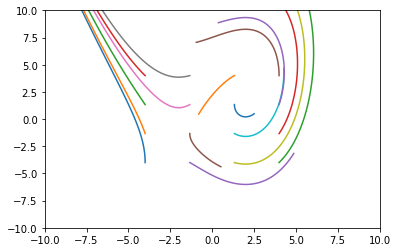

In [11]:
import numpy as np
from scipy.integrate import odeint, ode
import matplotlib.pyplot as plt

# Sistema de ecuaciones
def f(t, z):
    x = z[0]
    y = z[1]
    dxdt = x-y
    dydt = x**2-4
    return [dxdt, dydt]

# Integracion odeint
dt = 0.01
tmax = 1
t = np.arange(0, tmax, dt)
plt.figure()
Xi = np.linspace(-4, 4, 4)
Yi = np.linspace(-4, 4, 4)
plt.figure()
for xi in Xi:
    for yi in Yi:
        zi = [xi, yi]
        sol_fut = odeint(f, zi, t, tfirst=True)
        xt = sol_fut[:, 0]
        yt = sol_fut[:, 1]
        plt.plot(xt, yt)
plt.xlim(-10, 10)
plt.ylim(-10, 10)

En estos casos podemos usar otra estrategia en la que fijamos el método de integración. En vez de odeint vamos a usar un método bastante estandar, llamado [Runge-Kutta 4](https://es.wikipedia.org/wiki/M%C3%A9todo_de_Runge-Kutta)

RK4 es el caballito de batalla de los integradores numéricos, pero, como todo, tiene sus ventajas y desventajas, y va a funcionar mejor o peor según el sistema.

Lo bueno de este método es que pueden escribirlo ustedes mismos y no hay nada de caja negra! Para simplificar les vamos a proporcionar una versión que se adapta bastante bien si vienen de odeint.

Esta función ejecuta la integración de un paso temporal. Los argumentos que requiere son: i) campo vector (**función**) ii) valor de las variables en el tiempo t, iii) paso temporal

Los últimos dos (*args, **kwargs) son para que, en caso de que sus campos vectores tengan argumentos, se los puedan pasar a la función y los sepa manejar (más, adelante)

In [0]:
def rk4(dxdt, x, t, dt, *args, **kwargs):
    x = np.asarray(x)
    k1 = np.asarray(dxdt(x, t, *args, **kwargs))*dt
    k2 = np.asarray(dxdt(x + k1*0.5, t, *args, **kwargs))*dt
    k3 = np.asarray(dxdt(x + k2*0.5, t, *args, **kwargs))*dt
    k4 = np.asarray(dxdt(x + k3, t, *args, **kwargs))*dt
    return x + (k1 + 2*k2 + 2*k3 + k4)/6


La principal diferencia con odeint, es que en vez de pasarle el vector de tiempos, vamos a ir avanzando de a un paso temporal cada vez. Veamoslo con el ejemplo de Gompertz:

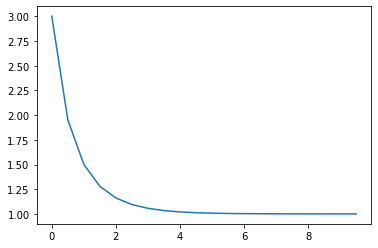

In [20]:
def dNdt(N, t):
    return -N*np.log(N)

# Definimos el paso temporal y el vector de tiempos
dt = 0.5
t = np.arange(0, 10, step=dt)
# Damos la condición inicial
N0 = 3
# Nos creamos un vector para guardar la solución
Nrk = np.zeros_like(t)
Nrk[0] = N0
for ix, tt in enumerate(t[:-1]):
    # Avanzamos un paso temporal
    Nrk[ix+1] = rk4(dNdt, Nrk[ix], tt, dt)
plt.plot(t, Nrk)

Comparemos ahora con el resultado de odeint. Prueben cambiar el paso temporal a ver qué pasa!

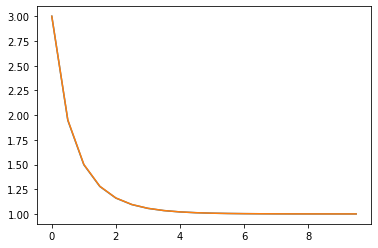

In [21]:
sol = odeint(dNdt, N0, t)
Nt = sol[:, 0]
plt.plot(t, Nt)
plt.plot(t, Nrk)

Veamos ahora el caso 2D y comparemos con odeint. Noten que el integrador nuevamente requiere que le pasemos el punto donde estamos como una lista (como le pasabamos la condición inicial a odeint!) y nos devuelve el x e y siguientes. La forma de atajar bien los valores es:

`x[i+1], y[i+1] = rk4(campo_vector, [x[i], y[i]], tt, dt)`

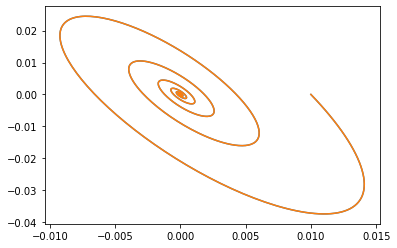

In [15]:
def campo_vector(z, t):
    # Como ahora las variables vienen en una lista (en el primer argumento: z)
    # primero las separamos para que sea más claro
    x = z[0]
    y = z[1]
    # Y ahora calculamos las derivadas
    dxdt = 4*x+2*y
    dydt = -17*x-5*y
    return [dxdt, dydt]

dt = 0.01
t = np.arange(0, 10, step=dt)
xrk = np.zeros_like(t)
yrk = np.zeros_like(t)
xrk[0] = 0.01
yrk[0] = 0

for ix, tt in enumerate(t[:-1]):
    xrk[ix+1], yrk[ix+1] = rk4(campo_vector, [xrk[ix], yrk[ix]], tt, dt)
plt.plot(xrk, yrk)
sol = odeint(campo_vector, [xrk[0], yrk[0]], t)
xt = sol[:, 0]
yt = sol[:, 1]
plt.plot(xt, yt)